In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functools
import sys

import datasets
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
import os
import torch.nn.functional as F

In [3]:
seed = 0
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(seed)

# Generate data

<IPython.core.display.Javascript object>


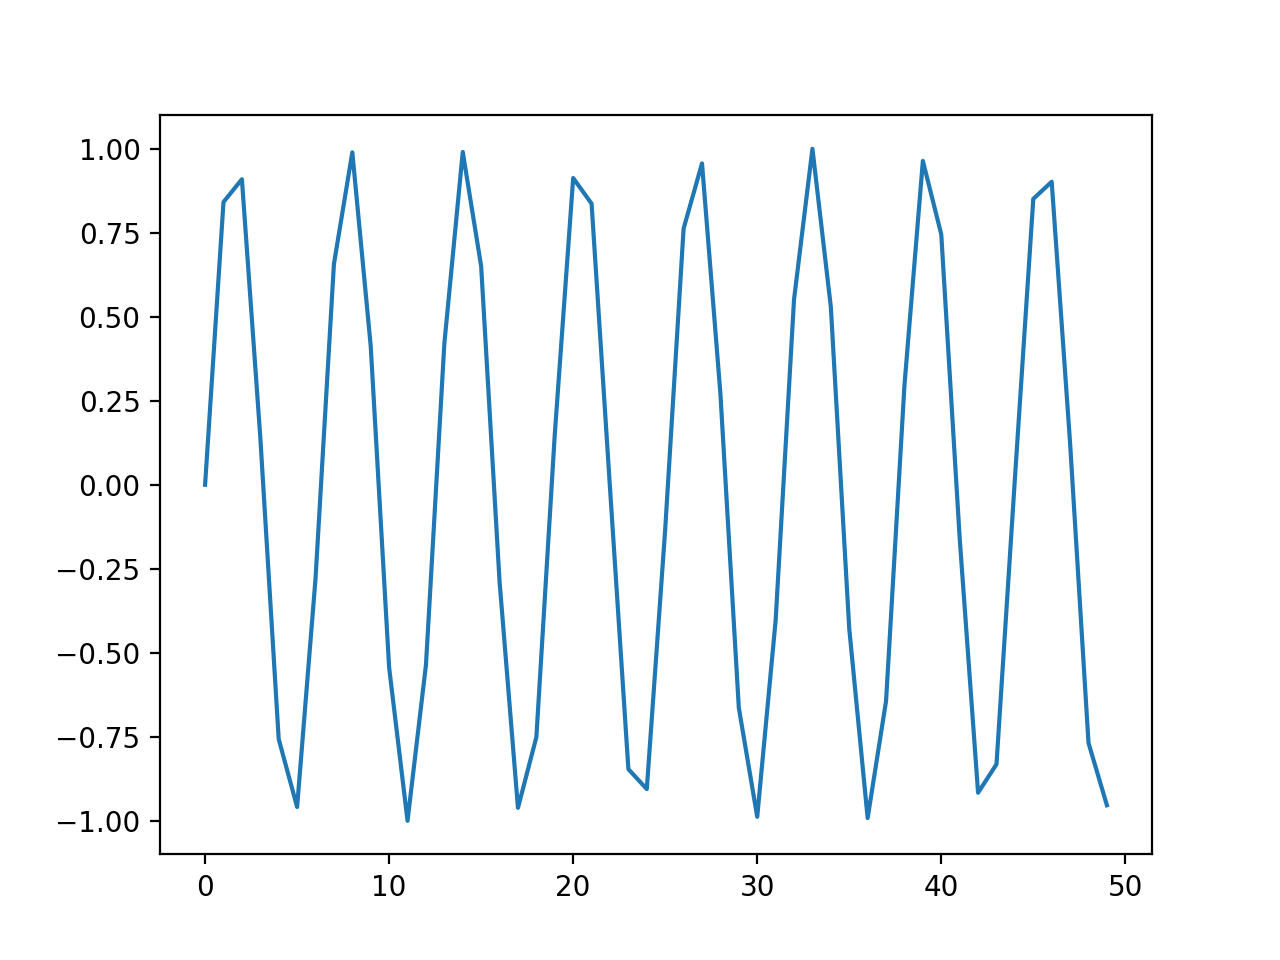

In [4]:
import math
sin_wave = np.array([math.sin(x) for x in np.arange(200)])
plt.plot(sin_wave[:50])

In [5]:
X = []
Y = []

seq_len = 50
num_records = len(sin_wave) - seq_len
val_num = 50
for i in range(num_records - val_num):
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])
    
X = np.array(X)
X = np.expand_dims(X, axis=2)

Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

In [6]:
X_val = []
Y_val = []

for i in range(num_records - val_num, num_records):
    X_val.append(sin_wave[i:i+seq_len])
    Y_val.append(sin_wave[i+seq_len])
    
X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)

Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)

In [7]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 32
X_total = np.concatenate((X, X_val), axis=0)
Y_total = np.concatenate((Y, Y_val), axis=0)
train_dataset = TensorDataset(torch.Tensor(X), torch.Tensor(Y))
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
val_dataset = TensorDataset(torch.Tensor(X_val), torch.Tensor(Y_val))
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=True)
total_dataset = TensorDataset(torch.Tensor(X_total), torch.Tensor(Y_total))
total_dataloader = DataLoader(total_dataset, 1, shuffle=False)

# Train Transformer

In [8]:
import torch.nn.functional as F
from models import count_parameters,  weights_init_normal, calculate_weights_diff, get_weights_list
from models import TransformerCuda as Transformer


def train(dataloader, model):
    total_loss = 0
    loss_func = nn.MSELoss()
    for data in dataloader:
        x = data[0].to(device)
        y = data[1].to(device)

        output =model(x)
        loss = loss_func(output,y)
        optimizer.zero_grad()
        weights1 = get_weights_list(model)
        loss.backward()
        optimizer.step()
        weights2 = get_weights_list(model)
#         print(calculate_weights_diff(weights1, weights2))
        total_loss += loss.item()
    total_loss /= len(dataloader)
    return total_loss

def validation(dataloader, model):
    total_loss = 0
    loss_func = nn.MSELoss()
    for data in dataloader:
        x = data[0].to(device)
        y = data[1].to(device)

        output =model(x)
        loss = loss_func(output,y)
        
        total_loss += loss.item()
    total_loss /= len(dataloader)
    return total_loss

In [9]:
learning_rate = 0.0001
nepoch = 300              
T = 50                   # length of sequence
hidden_dim = 512
output_dim = 1

model = Transformer(d=hidden_dim, d_in=1, depth=1)

print(f'The model has {count_parameters(model):,} trainable parameters')


model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
for name, p in model.named_parameters(): 
    print(name)

The model has 525,312 trainable parameters
embedding
readout
W1s.0
W2s.0


/Users/k/Desktop/ntk/models/transformer.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nn.Parameter(torch.tensor(torch.randn(d, d) * np.sqrt(vw).item()))


In [10]:
for epoch in range(nepoch):
    # check loss on train
    total_loss = train(train_dataloader, model)
    val_loss = validation(val_dataloader, model)
    print(epoch, total_loss, val_loss)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([18, 1])) that is different to the input size (torch.Size([18])). This will likely lead to incorrect results due to bro

0 0.484813816845417 0.5077817887067795
1 0.4644281044602394 0.48860011994838715
2 0.5162215605378151 0.5033446401357651
3 0.5255086272954941 0.4882252365350723
4 0.515321858227253 0.4741619676351547
5 0.45154887437820435 0.49109217524528503
6 0.500420942902565 0.5172223448753357
7 0.5158647373318672 0.4663347601890564
8 0.4886246845126152 0.48500651121139526
9 0.5252052396535873 0.4905301034450531
10 0.616698756814003 0.5108177661895752
11 0.5607880279421806 0.4912453144788742
12 0.4789443239569664 0.5010482966899872
13 0.5113067552447319 0.4970717579126358
14 0.45050081610679626 0.49151670932769775
15 0.4888306185603142 0.49859414994716644
16 0.5280535370111465 0.5144201964139938
17 0.507069505751133 0.5120808035135269
18 0.4824801981449127 0.5108650624752045
19 0.5035766139626503 0.4906213581562042
20 0.5485543012619019 0.49125878512859344
21 0.4877209886908531 0.5365696847438812
22 0.5324901938438416 0.5214999914169312
23 0.5163819044828415 0.4989028722047806
24 0.5421279817819595 0

197 0.4881224259734154 0.5287439525127411
198 0.5120915845036507 0.49096454679965973
199 0.5830077305436134 0.4775725156068802
200 0.45829153060913086 0.4886295348405838
201 0.5249664932489395 0.4885986000299454
202 0.5069712772965431 0.5070137977600098
203 0.5405650734901428 0.5183478593826294
204 0.5248259082436562 0.5315968841314316
205 0.5558063983917236 0.49938708543777466
206 0.5410458371043205 0.4749400019645691
207 0.47846636921167374 0.49832819402217865
208 0.5225489586591721 0.5059271305799484
209 0.555701494216919 0.5064723640680313
210 0.5464413017034531 0.5136604756116867
211 0.4528031274676323 0.475593164563179
212 0.48753946274518967 0.5054025799036026
213 0.5575909838080406 0.506135419011116
214 0.5883720815181732 0.4933277517557144
215 0.5900072604417801 0.5312367677688599
216 0.44473426043987274 0.49749431014060974
217 0.5107837617397308 0.49201419949531555
218 0.4729314297437668 0.5092699527740479
219 0.5070405304431915 0.5176281780004501
220 0.5470994859933853 0.518

# Calculate finite NTK

In [11]:
import gc
import time

from models import clone_grads, paramdot


def normalize_matrix(matrix):
    m = np.max(matrix)
    out = matrix / m
    return out

def get_finite_ntk_trained(model, dataloader):
    grads = []
    M = len(dataloader)
    print(M)
    i = 0
    loss_func = nn.MSELoss()
    for data in tqdm.tqdm(dataloader):
        if model.__class__.__name__ == "RNN":
            x = data[0].to(device)
            y = data[1].to(device)
        else:
            x = data[0].squeeze(dim=2).to(device)
            y = data[1].to(device)

        model.train()
        model.zero_grad()
        output =model(x)
        loss = loss_func(output,y)
        scale = 2*(output.item()-y.item())
        loss /= scale
        loss.backward()
        grads.append(clone_grads(model))
    
    finite_ntk = np.zeros((M,M))
    for i in tqdm.tqdm(range(M)):
        for j in range(i+1):
            finite_ntk[i, j] = finite_ntk[j, i] = paramdot(grads[i], grads[j])
    
    return finite_ntk

def get_finite_ntk(model, dataloader):
    grads = []
    M = len(dataloader)
    print(M)
    i = 0

    for data in tqdm.tqdm(dataloader):
        x = data[0].to(device)
        y = data[1].to(device)
        
        model.train()
        model.zero_grad()
        loss =model(x)
        loss.backward()
        grads.append(clone_grads(model))
    
    finite_ntk = np.zeros((M,M))
    for i in tqdm.tqdm(range(M)):
        for j in range(i+1):
            finite_ntk[i, j] = finite_ntk[j, i] = paramdot(grads[i], grads[j])
    
    return finite_ntk


finite_ntk_trained = get_finite_ntk(model, total_dataloader)

model_init = Transformer(d=hidden_dim, d_in=1, depth=1)
finite_ntk_init = get_finite_ntk(model_init, total_dataloader)

finite_ntk = finite_ntk_trained

150


100%|████████████████████████████████████████| 150/150 [00:00<00:00, 202.03it/s]


150


100%|████████████████████████████████████████| 150/150 [00:00<00:00, 199.40it/s]


# Calculate Inf NTK

In [12]:
from kernels import RNTK,TNTK
from kernels.utils import VErf3, VDerErf3

inps = X_total
inpcov = np.einsum('ais,bjs->aibj', inps, inps) / inps.shape[-1]
inf_ntk = TNTK(inpcov, depth=1)

# SVM

In [13]:
import numpy as np
import pandas as pd
from kernels import svr_search

train_fold_idx = np.array([[i for i in range(50)]])
test_fold_idx = np.array([[i for i in range(50,150)]])

# gram = finite_ntk
gram = inf_ntk

labels = Y_total.squeeze(axis=1)
results = svr_search(gram, labels, train_fold_idx, test_fold_idx)
results

,C,normalized,train,test
0,0.000100,False,-0.499359,-0.497498
1,0.000774,False,-0.499357,-0.497496
2,0.005995,False,-0.499337,-0.497478
3,0.046416,False,-0.499185,-0.497336
4,0.359381,False,-0.498013,-0.496245
5,2.782559,False,-0.489408,-0.488202
6,21.544347,False,-0.464088,-0.464325
7,166.810054,False,-0.452059,-0.452235
8,1291.549665,False,-0.450886,-0.450408
9,10000.000000,False,-0.450886,-0.450408
